[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [25]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/riyaa/Documents/code/mat496/langgraphmod4/studio/.env", override=True) #path to my env folder

True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [4]:
# Kernel 2
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

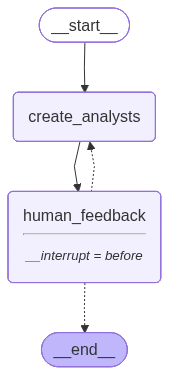

In [5]:
# Kernel 3
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
max_analysts = 3 
topic = "Large language models in medical diagnosis and patient care"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Anya Sharma
Affiliation: TechMed Innovations
Role: AI Diagnostics Specialist
Description: Focuses on the accuracy and reliability of LLMs in medical diagnosis, particularly in complex cases. Concerned about potential biases in algorithms and the need for rigorous validation.
--------------------------------------------------
Name: Marcus Chen
Affiliation: Patient Care Advocacy Group
Role: Patient Advocate
Description: Dedicated to ensuring patient well-being and equitable access to care.  His primary focus is on how LLMs can improve patient communication, personalize treatment plans, and address healthcare disparities, while also being wary of privacy concerns and the potential for misdiagnosis.
--------------------------------------------------
Name: Professor Emily Carter
Affiliation: Healthcare Ethics Institute
Role: Medical Ethicist
Description: Examines the ethical implications of using LLMs in patient care, including data privacy, algorithmic transparency, and the poten

In [7]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add a hospital CIO/IT implementation expert"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7270-2ae3-6e6e-8002-e528e3f85530'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Anya Sharma
Affiliation: TechMed Innovations
Role: AI Diagnostics Specialist
Description: Focuses on the accuracy and reliability of LLMs in medical diagnosis, particularly in complex cases. Concerned about potential biases in algorithms and the need for rigorous validation.
--------------------------------------------------
Name: Marcus Chen
Affiliation: Patient Care Advocacy Group
Role: Patient Advocate
Description: Dedicated to ensuring patient well-being and equitable access to care.  His primary focus is on how LLMs can improve patient communication, personalize treatment plans, and address healthcare disparities, while also being wary of privacy concerns and the potential for misdiagnosis.
--------------------------------------------------
Name: Professor Emily Carter
Affiliation: Healthcare Ethics Institute
Role: Medical Ethicist
Description: Examines the ethical implications of using LLMs in patient care, including data privacy, algorithmic transparency, and the poten

In [10]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7273-bdd2-64d9-8004-ec171a2a6592'}}

In [11]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [13]:
final_state.next

()

In [14]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Ava Patel
Affiliation: Tech Hospital
Role: AI Implementation Lead
Description: Focused on the practical challenges of integrating large language models into existing hospital IT infrastructure, ensuring data security and patient privacy, and addressing interoperability issues with legacy systems.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: Medical AI Research Institute
Role: AI Diagnostics Researcher
Description: Dedicated to exploring the potential of large language models in improving the accuracy and efficiency of medical diagnoses, with a particular interest in rare diseases and complex cases.
--------------------------------------------------
Name: Maria Rodriguez
Affiliation: Patient Advocacy Group
Role: Patient Care Advocate
Description: Passionate about ensuring that large language models are used ethically and responsibly in patient care, with a focus on accessibility, transparency, and minimizing bias in treatment recommendations

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [19]:

import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interviews: Annotated[list, operator.add] # Raw interview data for peer review

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [20]:

question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [17]:
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.utilities import PubMedAPIWrapper

tavily_search = TavilySearch(max_results=3)
pubmed = PubMedAPIWrapper()

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [27]:
!pip install google-search-results

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32083 sha256=01055770f8afcda3553791769c517c27604c87e2968c3f8dbddc5ac5474b8abe
  Stored in directory: c:\users\riyaa\appdata\local\pip\cache\wheels\44\af\e2\dde9fab6f1876485b72b35e9cd48da741da67d20e617c3b971
Successfully built google-search-results


  DEPRECATION: Building 'google-search-results' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'google-search-results'. Discussion can be found at https://github.com/pypa/pip/issues/6334


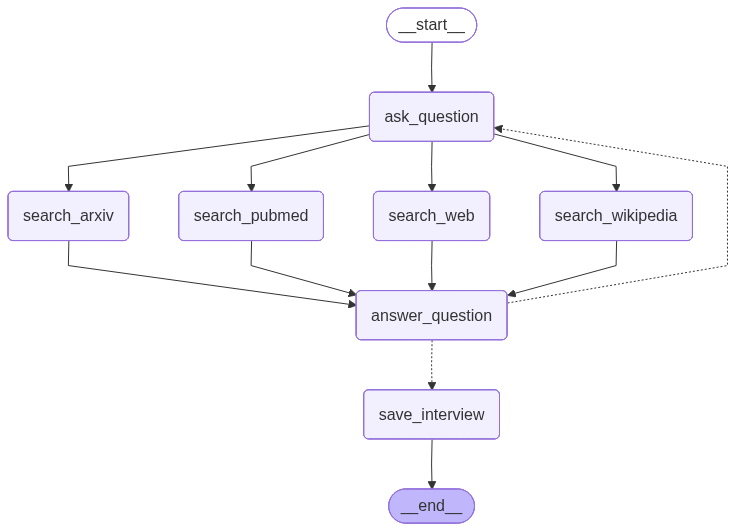

In [34]:
# Kernel 15
from langchain_core.messages import get_buffer_string
from langchain_community.document_loaders import ArxivLoader

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_pubmed(state: InterviewState):
    
    """ Retrieve docs from PubMed """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_results = pubmed.run(search_query.search_query)
    
    # Format
    formatted_search_docs = f'<Document source="PubMed"/>\n{search_results}\n</Document>'

    return {"context": [formatted_search_docs]}

def search_arxiv(state: InterviewState):
    
    """ Retrieve docs from arXiv """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    try:
        # Search arXiv
        search_docs = ArxivLoader(query=search_query.search_query, load_max_docs=2).load()
        
        # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="arXiv" id="{doc.metadata.get("entry_id", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
                for doc in search_docs
            ]
        )
    except Exception as e:
        # If search fails, return empty result
        formatted_search_docs = f'<Document source="arXiv"/>\nNo results found for this query.\n</Document>'

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    analyst = state["analyst"]
    context = state["context"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Package interview with analyst info and context
    interview_data = {
        "analyst": analyst,
        "interview": interview,
        "context": context
    }
    
    # Save to interviews key
    return {"interviews": [interview_data]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_pubmed", search_pubmed)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("ask_question", "search_pubmed")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_pubmed", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Hospital', name='Ava Patel', role='AI Implementation Lead', description='Focused on the practical challenges of integrating large language models into existing hospital IT infrastructure, ensuring data security and patient privacy, and addressing interoperability issues with legacy systems.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [35]:

from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
# Note: interviews now returns interview data dict, not sections
print("Interview completed for:", interview['interviews'][0]['analyst'].name)

Interview completed for: Ava Patel


### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [39]:
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    interviews: Annotated[list, operator.add] # Interview results  
    peer_reviews: Annotated[list, operator.add] # Peer review results
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    executive_summary: str # Executive summary with confidence ratings
    final_report: str # Final report

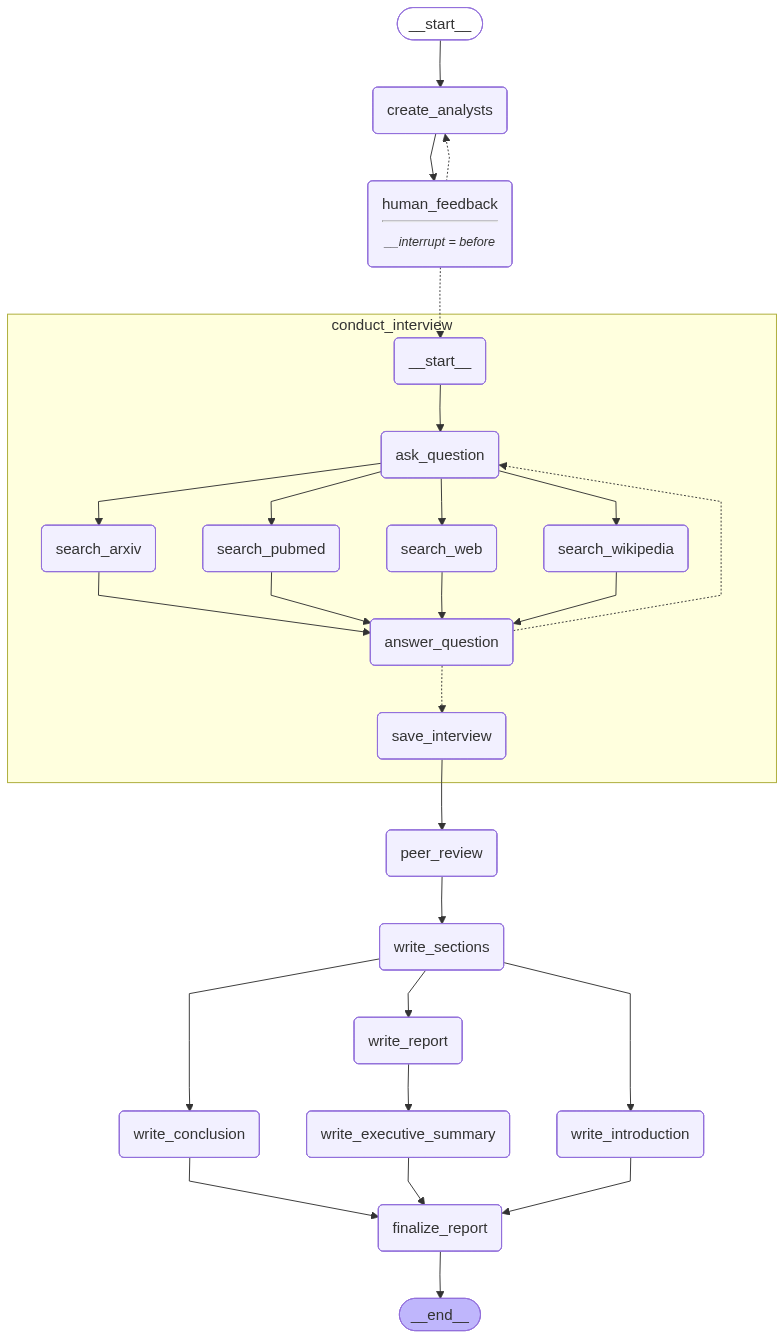

In [41]:

import operator
from typing import Annotated
from langgraph.types import Send

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    interviews: Annotated[list, operator.add] # Interview results  
    peer_reviews: Annotated[list, operator.add] # Peer review results
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    executive_summary: str # Executive summary with confidence ratings
    final_report: str # Final report

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

peer_review_instructions = """You are an analyst reviewing findings from a colleague's research.

Your colleague: {peer_name} ({peer_role})
Their research focus: {peer_focus}

Their interview transcript and sources:
{peer_interview}

Your own research focus: {own_focus}

Provide a brief peer review (150-200 words) addressing:
1. How their findings relate to or complement your research area
2. Key insights that strengthen the overall research
3. Any gaps, conflicts, or concerns you identify
4. Confidence level in their findings (HIGH/MEDIUM/LOW) with brief justification

Be constructive and focus on synthesis opportunities."""

def conduct_peer_review(state: ResearchGraphState):
    """ Analysts review each other's raw interview findings """
    
    interviews = state["interviews"]
    analysts = state["analysts"]
    
    peer_reviews = []
    
    # Each analyst reviews all other analysts' interviews
    for i, reviewer in enumerate(analysts):
        for j, interview_data in enumerate(interviews):
            reviewed_analyst = interview_data["analyst"]
            # Don't review your own work
            if reviewer.name != reviewed_analyst.name:
                system_message = peer_review_instructions.format(
                    peer_name=reviewed_analyst.name,
                    peer_role=reviewed_analyst.role,
                    peer_focus=reviewed_analyst.description,
                    peer_interview=interview_data["interview"],
                    own_focus=reviewer.description
                )
                review = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Provide your peer review.")])
                peer_reviews.append({
                    "reviewer": reviewer.name,
                    "reviewed": reviewed_analyst.name,
                    "review": review.content
                })
    
    return {"peer_reviews": peer_reviews}

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on interview findings and peer feedback.

1. Analyze the interview transcript and source documents.

2. Consider the peer reviews which may highlight:
   - Connections to other research areas
   - Potential conflicts or gaps
   - Confidence levels in findings

3. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
4. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

5. Make your title engaging based upon the focus area: {focus}

6. For the summary section:
- Set up summary with general background / context
- Emphasize what is novel, interesting, or surprising
- Address any concerns raised in peer reviews
- Acknowledge areas of uncertainty if identified
- Create a numbered list of source documents as you use them
- Do not mention analyst or expert names
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2])
        
7. In the Sources section:
- Include all sources used
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline with two spaces at the end
- Combine redundant sources

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title
- Check that all guidelines have been followed

Interview transcript:
{interview}

Source documents:
{context}

Peer reviews of this research:
{peer_reviews}"""

def write_sections(state: ResearchGraphState):
    """ Write sections incorporating peer feedback """
    
    interviews = state["interviews"]
    peer_reviews = state.get("peer_reviews", [])
    
    sections = []
    
    for interview_data in interviews:
        analyst = interview_data["analyst"]
        interview = interview_data["interview"]
        context = interview_data["context"]
        
        # Get peer reviews for this analyst
        relevant_reviews = [pr["review"] for pr in peer_reviews if pr["reviewed"] == analyst.name]
        formatted_reviews = "\n\n".join(relevant_reviews) if relevant_reviews else "No peer reviews available."
        
        # Write section
        system_message = section_writer_instructions.format(
            focus=analyst.description,
            interview=interview,
            context=context,
            peer_reviews=formatted_reviews
        )
        section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Write the section incorporating peer feedback.")])
        sections.append(section.content)
    
    return {"sections": sections}

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst:
1. Conducted an interview with an expert
2. Received peer reviews from colleagues
3. Wrote a memo incorporating that feedback

Your task: 

1. You will be given memos that already incorporate peer review insights.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together central ideas. 
4. Summarize the central points into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(
        topic=topic, 
        context=formatted_str_sections
    )    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

executive_summary_instructions = """You are creating an executive summary with confidence ratings for a research report on {topic}.

Based on the full report content and the collaborative research process, create a brief executive summary (150-200 words) that includes:

1. 3-5 key findings with confidence levels
2. Critical insights that surprised or stood out
3. Areas of uncertainty or conflicting evidence identified during peer review

For each key finding, assign a confidence level:
- HIGH: Strongly supported by multiple sources and analyst agreement
- MEDIUM: Supported but with some gaps or minor conflicts noted
- LOW: Limited evidence or significant uncertainty identified

Format as:
## Executive Summary

**Key Finding 1** (Confidence: HIGH/MEDIUM/LOW)
Brief description

**Key Finding 2** (Confidence: HIGH/MEDIUM/LOW)
Brief description

Continue for all findings, then add a brief note on overall research confidence and collaboration quality.

Here is the full report content:
{content}"""

def write_executive_summary(state: ResearchGraphState):
    content = state["content"]
    topic = state["topic"]
    
    instructions = executive_summary_instructions.format(
        topic=topic,
        content=content
    )
    
    exec_summary = llm.invoke([SystemMessage(content=instructions)]+[HumanMessage(content="Write the executive summary with confidence ratings.")])
    
    return {"executive_summary": exec_summary.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    exec_summary = state.get("executive_summary", "")
    final_report = state["introduction"] + "\n\n---\n\n" + exec_summary + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("peer_review", conduct_peer_review)
builder.add_node("write_sections", write_sections)
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("write_executive_summary",write_executive_summary)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "peer_review")
builder.add_edge("peer_review", "write_sections")
builder.add_edge("write_sections", "write_report")
builder.add_edge("write_sections", "write_introduction")
builder.add_edge("write_sections", "write_conclusion")
builder.add_edge("write_report", "write_executive_summary")
builder.add_edge(["write_conclusion", "write_executive_summary", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [42]:

# Inputs
max_analysts = 3 
topic = "Large language models in medical diagnosis and patient care"
thread = {"configurable": {"thread_id": "1"}}
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Anya Sharma
Affiliation: TechMed Innovations
Role: AI Ethics Consultant
Description: Focuses on the ethical implications of using LLMs in medical diagnosis, ensuring patient privacy, data security, and algorithmic fairness.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: Global Health Analytics
Role: Medical Data Analyst
Description: Concerned with the accuracy and reliability of LLMs in diagnosing diseases, particularly in underserved communities with limited access to healthcare resources.
--------------------------------------------------
Name: Ms. Chloe Davis
Affiliation: Patient Care Advocates
Role: Patient Advocate
Description: Dedicated to ensuring that LLMs enhance patient care and improve patient outcomes, while also emphasizing the importance of human oversight and personalized treatment plans.
--------------------------------------------------


In [43]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add a hospital CIO/IT implementation expert"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7311-03b8-6896-8002-37d2b22aeb47'}}

In [44]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: TechMed Innovations
Role: AI Ethics Consultant
Description: Focuses on the ethical implications of using LLMs in medical diagnosis, ensuring patient privacy, data security, and algorithmic fairness.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: Global Health Analytics
Role: Medical Data Analyst
Description: Concerned with the accuracy and reliability of LLMs in diagnosing diseases, particularly in underserved communities with limited access to healthcare resources.
--------------------------------------------------
Name: Ms. Chloe Davis
Affiliation: Patient Care Advocates
Role: Patient Advocate
Description: Dedicated to ensuring that LLMs enhance patient care and improve patient outcomes, while also emphasizing the importance of human oversight and personalized treatment plans.
--------------------------------------------------
Name: Ava Patel
Affiliation: Tech Hospital
Role: CIO
Description: Focused on the IT in

In [45]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7311-c294-6ab4-8004-27920fec62f7'}}

In [47]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
write_executive_summary
--Node--
finalize_report


In [48]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Promise and Peril of LLMs in Healthcare

## Introduction

This report explores the multifaceted impact of Large Language Models (LLMs) on medical diagnosis and patient care. We begin by examining the potential of LLMs in the early diagnosis of rare genetic disorders, highlighting both their surprising accuracy and tendency towards over-diagnosis. Next, we delve into the ethical minefield of "epistemic injustice," where LLMs risk devaluing patients' subjective experiences and intuitive knowledge. Finally, we address the practical challenges of integrating LLMs into healthcare IT infrastructure, focusing on data security, legacy system compatibility, and HIPAA compliance. This analysis underscores the need for careful consideration of both the benefits and risks associated with LLM implementation in medicine.

---

## Executive Summary

**Key Finding 1** (Confidence: HIGH)
LLMs show promise in early detection of rare genetic disorders by identifying subtle connections between symptoms that might be missed by clinicians. However, realizing this potential is contingent on addressing challenges related to data security, ethical considerations, and diagnostic accuracy.

**Key Finding 2** (Confidence: MEDIUM)
Integrating LLMs with existing legacy EMR systems presents a significant technical hurdle. The development of custom APIs for real-time data exchange introduces both expense and potential security vulnerabilities. While de-identification techniques are employed, concerns remain about potential re-identification and the impact on LLM accuracy.

**Key Finding 3** (Confidence: MEDIUM)
LLMs may perpetuate epistemic injustice by prioritizing "objective" data over patients' subjective experiences. This is especially problematic in diagnosing rare or poorly understood conditions, potentially silencing patient voices and hindering holistic diagnoses, particularly within marginalized communities.

**Key Finding 4** (Confidence: MEDIUM)
LLMs exhibit a tendency to "over-diagnose," leading to higher false positive rates. This raises concerns about data bias, algorithmic transparency, and the potential for increased patient anxiety and unnecessary testing. Further research is needed to validate findings and mitigate the risks associated with false positives.

Overall research confidence is considered medium, reflecting the inherent limitations of current data and the evolving nature of LLM technology. Collaboration throughout the research process was strong, facilitating robust discussion and critical evaluation of the evidence.

---



The integration of Large Language Models (LLMs) into medical diagnosis and patient care presents a complex landscape of opportunities and challenges. While LLMs demonstrate promise in areas such as early detection of rare genetic disorders [1, 2], their implementation raises critical concerns related to data security, ethical considerations, and diagnostic accuracy.

A significant hurdle lies in integrating LLMs with existing legacy Electronic Medical Record (EMR) systems. Many healthcare providers rely on older systems not designed for the real-time data exchange that LLMs require, which necessitates the development of custom APIs [3]. These APIs can be expensive and introduce potential security vulnerabilities [2]. Moreover, the need to de-identify patient data before use raises concerns about potential re-identification, even with techniques like differential privacy, which can impact LLM accuracy [1, 3]. Maintaining rigorous security protocols while fostering innovation requires a critical balancing act.

Beyond technical challenges, ethical considerations surrounding epistemic injustice demand attention. LLMs risk devaluing patients' subjective experiences by prioritizing "objective" data [5, 6, 7]. This is particularly problematic in diagnosing rare or poorly understood conditions where a patient's intuitive understanding of their symptoms may be dismissed. Such devaluation can silence patient voices and hinder accurate, holistic diagnoses, especially within marginalized communities [8, 9].

Furthermore, while LLMs can identify subtle connections between seemingly unrelated symptoms, potentially leading to earlier diagnosis of rare diseases, they also exhibit a tendency to "over-diagnose," resulting in higher false positive rates [3, 4]. This tendency raises concerns about data bias, algorithmic transparency, and the potential for increased patient anxiety and unnecessary testing. Rigorous clinical trials with larger, diverse datasets are necessary to validate these findings and mitigate the risks associated with false positives. Further research should focus on the cost-effectiveness of LLM-assisted diagnosis compared to traditional methods.

Ultimately, successful implementation of LLMs in healthcare requires careful consideration of data security, ethical implications, and diagnostic accuracy. Addressing these challenges is crucial to harnessing the potential benefits of LLMs while safeguarding patient well-being and promoting equitable healthcare practices.


---

## Conclusion

LLMs present a complex landscape for medical diagnosis and patient care. While showing promise in early detection of rare genetic disorders, even outperforming specialists in some instances, the risk of over-diagnosis and false positives remains a concern. Further, the integration of LLMs with legacy healthcare systems poses data security and interoperability challenges, demanding careful navigation of HIPAA compliance and custom API development. Beyond technical hurdles, the potential for epistemic injustice, where patient experiences are devalued, requires careful consideration. Successfully deploying LLMs in healthcare necessitates balancing innovation with ethical considerations, data security, and the imperative to amplify, not silence, patient voices.

## Sources

[1] styrk.ai/balancing-llm-innovation-with-security/
[2] https://www.rsna.org/news/2025/may/llm-cybersecurity-threats
[3] sphereinc.com/blogs/data-for-llm-healthcare/
[4] medium.com/@projects_24920/leveraging-on-premise-llms-in-healthcare-navigating-hipaa-compliance-9e34a518430c
[5] JMIR: J Med Internet Res. 2024;26:e60083. https://www.jmir.org/2024/1/e60083/
[6] Review of ChatGPT-based Diagnostic Medicine Applications. https://pmc.ncbi.nlm.nih.gov/articles/PMC10898121/
[7] BMC Medical Informatics and Decision Making. https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-024-02656-3
[8] Ethics of artificial intelligence - Wikipedia. https://en.wikipedia.org/wiki/Ethics_of_artificial_intelligence
[9] Epistemic Injustice in Medical AI. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5212457
[10] G. Pozzi, PhD Dissertation. https://research.tudelft.nl/files/180125148/PhD_Dissertation_G_Pozzi.pdf
[11] J Med Ethics 2023;49:536-540. https://jme.bmj.com/content/49/8/536
[12] Twice exceptional - Wikipedia. https://en.wikipedia.org/wiki/Twice_exceptional
[13] Disability - Wikipedia. https://en.wikipedia.org/wiki/Disability
[14] https://ggc.org/lysosomal-storage-disorders-gaucher-and-fabry-disease/
[15] https://pubmed.ncbi.nlm.nih.gov/39384207/
[16] https://worldsymposia.org/worldsymposium-2025-speed-mentoring/
[17] https://intuitionlabs.ai/articles/llm-physician-diagnostic-accuracy

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r